In [1]:
import pickle
import os
import sys
import functools
from tqdm import notebook

sys.path.append('../../../libraries/') # Append the path within which the user-defined class is in
from data_loader import data_loader
from behavior_loader import bsoid_loader

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import umap
import hdbscan

from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [2]:
data_dir = r'../../../processed_data'

### Load 4-hour z-scored bandpower features of lpf using Welch method

In [3]:
zscore_feats = pickle.load(open(os.path.join(data_dir, 'welch_bp/welch_nonoverlap_zscore_bp_0.0_s_offset.np'), 'rb'))
print(f'Z-scored bandpower features are binned into shape: {zscore_feats.shape}')

Z-scored bandpower features are binned into shape: (48, 14400)


### Naive repetitive windows

In [4]:
zscore_feats_naive = np.repeat(zscore_feats, 10, axis=1)

### Load best umap-hdbscan model that seperates lpf most clearly and predict on lpf features

In [5]:
def rf_f1_score(X, y, test_size=0.2, average='macro'):
    sample_size = np.ceil(1 / test_size) * 4
    targets, target_cnts = np.unique(y, return_counts=True)
    X_train_arr = [] 
    X_test_arr = [] 
    y_train_arr = [] 
    y_test_arr = []
    for i, target_cnt in enumerate(target_cnts):
        if target_cnt >= sample_size:
            target_idcs = np.where(y == targets[i])[0]
            X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[target_idcs, :], y[target_idcs], test_size=test_size, random_state=42)
            X_train_arr.append(X_train_target)
            X_test_arr.append(X_test_target)
            y_train_arr.append(y_train_target)
            y_test_arr.append(y_test_target)
    X_train = np.vstack(X_train_arr)
    X_test = np.vstack(X_test_arr)
    y_train = np.hstack(y_train_arr)
    y_test = np.hstack(y_test_arr)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)

    return f1_score(y_test, predict, average=average)

In [6]:
def umap_hdbscan_rf_segment(data, n_components, n_neighbors, min_dist, random_state_umap, min_cluster_size, min_samples):
    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state_umap)
    embedding = reducer.fit_transform(data)
    clusterer_umap = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, prediction_data=True).fit(embedding)
    X = data[clusterer_umap.labels_ >= 0, :]
    y = clusterer_umap.labels_[clusterer_umap.labels_ >= 0]
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X, y)
    y_all = clf.predict(data)

    return y_all

In [7]:
lfp_states = umap_hdbscan_rf_segment(data=zscore_feats.T,
                                     n_components=5,
                                     n_neighbors=60,
                                     min_dist=0,
                                     random_state_umap=29,
                                     min_cluster_size=150,
                                     min_samples=20)

### Naive repetitive windows

In [8]:
lfp_predict_naive = np.repeat(lfp_states, 10)

### Load 4-hour l5 spikes

In [9]:
with open(os.path.join(data_dir, 'all_fr0.1hz_30hz_0s_14400s_0.1s_bins_nooverlap.npy'), 'rb') as file:
    spike_times_all_neurons = np.load(file)

# Convert to numpy array
spike_times_all_neurons = np.array(spike_times_all_neurons)

# # (Number of 100-ms bins, Number of l2 neurons)
# T_1h, D_m1 = spike_times_all_neurons_1h.shape

# Z-score each neuron, i.e. firing rates of each neuron across time sum to 0
spike_times_all_neurons_4h_zscored = stats.zscore(spike_times_all_neurons) # Default axis is 0

spikes = spike_times_all_neurons_4h_zscored
print(f'Spike times are binned into shape: {spikes.shape}')

Spike times are binned into shape: (143999, 363)


In [10]:
spikes = np.vstack([spikes, np.random.rand(1, 363)])
spikes.shape

(144000, 363)

### Load 4-hour behaviors

In [11]:
# Load behaviors
behavior_loader = bsoid_loader(data_dir, 'ag25290_day2_iter13')
f_index, filtered_data, smoothed_predictions = behavior_loader.main()

# Correct prediction start
framerate = 60
delay = 6.8503
behavior_start = int(delay * framerate)  # start of behavior
smoothed_predictions_4h = smoothed_predictions[behavior_start:(behavior_start+(3600*60)*4):int(60/10)]
smoothed_predictions_4h.shape

Mouse stayed in nest for 0.28108749470484795% of time
Smooth window: 6
File #0 (a 6 body parts by 984391 frames) has 30 classes


(144000,)

### Split into 3 hour for train and 1 hour for test

In [12]:
train_hours = 3

bp_naive_train = zscore_feats_naive.T[:60*60*10*train_hours]
bp_naive_test = zscore_feats_naive.T[60*60*10*train_hours:]

lfp_predict_naive_train = lfp_predict_naive[:60*60*10*train_hours]
lfp_predict_naive_test = lfp_predict_naive[60*60*10*train_hours:]

spikes_train = spikes[:60*60*10*train_hours]
spikes_test = spikes[60*60*10*train_hours:]

smoothed_predictions_train = smoothed_predictions_4h[:60*60*10*train_hours]
smoothed_predictions_test = smoothed_predictions_4h[60*60*10*train_hours:]

In [13]:
behavior_of_interest_0 = np.array([6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 28])

In [14]:
def rf_f1_score(X, y, y_interested, test_size=0.2, random_state=42):
    sample_size = np.ceil(1 / test_size) * 4
    targets, target_cnts = np.unique(y, return_counts=True)
    X_train_arr = [] 
    X_test_arr = [] 
    y_train_arr = [] 
    y_test_arr = []
    for i, target_cnt in enumerate(target_cnts):
        if targets[i] in y_interested and target_cnt >= sample_size:
            target_idcs = np.where(y == targets[i])[0]
            X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[target_idcs, :], y[target_idcs], test_size=test_size, random_state=random_state)
            X_train_arr.append(X_train_target)
            X_test_arr.append(X_test_target)
            y_train_arr.append(y_train_target)
            y_test_arr.append(y_test_target)
    X_train = np.vstack(X_train_arr)
    X_test = np.vstack(X_test_arr)
    y_train = np.hstack(y_train_arr)
    y_test = np.hstack(y_test_arr)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)

    return clf, np.unique(y_test), f1_score(y_test, predict, average='micro')

### Training state-aware classifier using 3 hour data

In [15]:
state_clf_dict = {}
for lfp_state in notebook.tqdm(np.unique(lfp_predict_naive_train)):
    seg_idcs = np.where(lfp_predict_naive_train == lfp_state)[0]
    state_spikes = spikes_train[seg_idcs, :]
    state_smoothed_predictions = smoothed_predictions_train[seg_idcs]      
    state_clf, _, state_f1_score = rf_f1_score(state_spikes, state_smoothed_predictions, behavior_of_interest_0)
    print(state_f1_score)
    state_clf_dict[lfp_state] = state_clf

  0%|          | 0/10 [00:00<?, ?it/s]

0.4264524103831891
0.5003119151590767
0.48478327697509993
0.5080740448995668
0.5219907407407407
0.513713862120089
0.5613207547169812
0.4825918762088975
0.4859922178988327
0.5484972677595629


In [16]:
lfp_clf, _, lfp_f1_score = rf_f1_score(bp_naive_train, lfp_predict_naive_train, np.unique(lfp_predict_naive_train))
print(lfp_f1_score)

1.0


In [17]:
f1_score(lfp_clf.predict(bp_naive_test), lfp_predict_naive_test, average='micro')

0.8933333333333333

### Test using 'true' lfp labels

In [18]:
behav_predict = np.zeros(len(smoothed_predictions_test))
for lfp_state in notebook.tqdm(np.unique(lfp_predict_naive_test)):
    lfp_state_idx = np.where(lfp_predict_naive_test == lfp_state)[0]
    behav_predict[lfp_state_idx] = state_clf_dict[lfp_state].predict(spikes_test[lfp_state_idx, :])

  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
f1_score(behav_predict, smoothed_predictions_test, average='micro')

0.44455555555555554

### Test using predicted lfp labels

In [20]:
behav_predict = np.zeros(len(smoothed_predictions_test))
lfp_predict = lfp_clf.predict(bp_naive_test)
for lfp_state in notebook.tqdm(np.unique(lfp_predict)):
    lfp_state_idx = np.where(lfp_predict == lfp_state)[0]
    behav_predict[lfp_state_idx] = state_clf_dict[lfp_state].predict(spikes_test[lfp_state_idx, :])
f1_score(behav_predict, smoothed_predictions_test, average='micro')

  0%|          | 0/10 [00:00<?, ?it/s]

0.4465

In [21]:
np.unique(behav_predict)

array([ 6.,  7.,  8.,  9., 10., 14., 15., 16., 17., 18., 20., 21., 22.,
       23., 24., 25., 26., 28.])

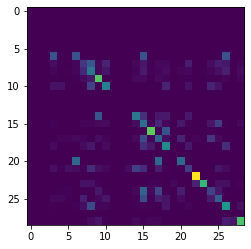

In [22]:
cm = confusion_matrix(behav_predict, smoothed_predictions_test, normalize='true')
plt.imshow(cm)